#DATASCI W261: Machine Learning at Scale 

* **Sayantan Satpati**
* **sayantan.satpati@ischool.berkeley.edu**
* **W261**
* **Week-14**
* **Assignment-14**
* **Date of Submission: 16-DEC-2015**

#  === Week 13 ASSIGNMENTS [Modified in Week 14] ===

***Modified Sections have only been submitted***

##  Initialize Spark in Local

In [160]:
SPARK_HOME="/Users/ssatpati/0-DATASCIENCE/TOOLS/spark-1.5.1-bin-hadoop2.6"

In [3]:
import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = SPARK_HOME
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


## HW 13.2
___

===HW 13.2: Applying PageRank to the Wikipedia hyperlinks network===

Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

NOTE: Wikipedia data is located on S3 at  s3://ucb-mids-mls-networks/wikipedia/
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids

### [Modified HW13] Page Rank Version 3.0 - Back to Using 1 RDD

***Scalable Solution using Paritioned Joins***

***Each iteration took 4 mins with 10 m3.xlarge VM(s)***

In [161]:
%%writefile spark_13_2_v2.py
import ast
import pprint
import sys
from math import log, exp, log1p
from pyspark import SparkContext
from pyspark import SparkConf

#global Var
g_dangling_mass = None

def u(s):
    return s.decode('utf-8')

def parse_line(line):
    tokens = line.split('\t')
    key = tokens[0]
    adj_list = ast.literal_eval(tokens[1])
    return (u(key), [u(k) for k,v in adj_list.iteritems()])

def preproc(t):
    l = [t]
    for x in t[1]:
        l.append((u(x),[]))
    return l

def contributions(t):
    #global g_dangling_mass
    l = [(t[0], 0)]
    w = t[1][1]
    adj_list = t[1][0]
    key = None
    if len(adj_list) == 0:
        #g_dangling_mass += w
        l.append(('DANGLING', w))
    else:
        for n in adj_list:
            l.append((n, w/len(adj_list)))
    return l

def page_rank(w, n, dangling_mass, LH, RH):
    # w = (tp / n) + (1 - tp) * ((dangling_mass/n) + w)
    # OR
    # w = (tp / n) + ((1 - tp)/n) * (dangling_mass + wn)
    # OR
    # w = LH + RH * (dangling_mass + wn)
    # OR
    # w = LH + exp(log(RH) + log(dangling_mass + wn))
    
    w = LH + exp(log(RH) + log(dangling_mass + w * n))
    return w

if __name__ == '__main__':
    print 'Number of arguments:', len(sys.argv), 'arguments.'
    print 'Argument List:', str(sys.argv)
    
    if len(sys.argv) != 5:
        print 'Incorrect number of arguments passed, Aborting...'
        sys.exit(1)
        
    # Init Spark Context
    #conf = SparkConf()
    sc = SparkContext(appName="Page Rank")
    
    lines = sc.textFile(sys.argv[1]).map(parse_line)
    #print '\n### Original Dataset:'
    #pprint.pprint(lines.sortByKey().collect())

    # Cache the linkys (They are Bigger)
    num_partitions = int(sys.argv[4])
    links = lines.flatMap(preproc) \
                 .reduceByKey(lambda x, y: x + y) \
                 .partitionBy(num_partitions) \
                 .cache()
    #print '\n### Pre-Processed Dataset (Links):'
    #pprint.pprint(links.collect())

    # Use map values to partition ranks in the same way as links
    n = links.count()
    ranks = links.mapValues(lambda x: float(1)/n)
    #print '\n### Inital Ranks:'
    #pprint.pprint(ranks.collect())

    #sum_partial_diff_PR = float('inf')
    #Teleportation & Damping Factor (Calculate & Pass)
    tp=0.15
    LH = tp / n
    RH = (1 - tp) / n
    sys.stderr.write('### Teleportation: {0}, LH: {1}, RH: {2}'.format(tp, LH, RH))
    cnt = 1

    #while sum_partial_diff_PR > .005:
    while cnt <= int(sys.argv[3]):
        #global g_dangling_mass
        #g_dangling_mass = sc.accumulator(0.0)
        contribs = links.join(ranks) \
                    .flatMap(contributions) \
                    .reduceByKey(lambda x, y: x + y)
        dangling_mass = contribs.lookup('DANGLING')[0]
        ranks = contribs.filter(lambda x: x[0] != 'DANGLING') \
                        .mapValues(lambda x: page_rank(x, n, dangling_mass, LH, RH))
        sys.stderr.write('\n[{0}] Dangling Mass: {1}'.format(cnt, dangling_mass))
    
        cnt += 1

    sc.parallelize(ranks.takeOrdered(100, key=lambda x: -x[1])).saveAsTextFile(sys.argv[2])
    
    sc.stop()


Writing spark_13_2_v2.py


In [162]:
!chmod u+x spark_13_2_v2.py

In [132]:
out_dir = "output_13_3"
!rm -rf $out_dir
!time $SPARK_HOME/bin/spark-submit --name "Page Rank" --master local[4] ./spark_13_2_v2.py \
                PageRank-test.txt $out_dir 30 4
!cat $out_dir/part-000*

Number of arguments: 5 arguments.
Argument List: ['/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk14/./spark_13_3.py', 'PageRank-test.txt', 'output_13_3', '30', '4']
2015-12-13 08:03:06.490 java[68251:26759218] Unable to load realm mapping info from SCDynamicStore
### Teleportation: 0.15, LH: 0.0136363636364, RH: 0.0772727272727
[1] Dangling Mass: 0.0909090909091
[2] Dangling Mass: 0.0592975206612
[3] Dangling Mass: 0.0379464062109
[4] Dangling Mass: 0.0640190695934
[5] Dangling Mass: 0.0375959647951
[6] Dangling Mass: 0.0386749363905
[7] Dangling Mass: 0.0341177257382
[8] Dangling Mass: 0.0346526855821
[9] Dangling Mass: 0.0332641479909
[10] Dangling Mass: 0.0332687068063
[11] Dangling Mass: 0.0329301017862
[12] Dangling Mass: 0.0329194443643
[13] Dangling Mass: 0.0328282893463
[14] Dangling Mass: 0.0328197384167
[15] Dangling Mass: 0.0327957341511
[16] Dangling Mass: 0.0327922737609
[17] Dangling Mass: 0.0327858041648
[18] Dangling Mass: 0.0327845372023
[19] Dangling Mass: 0.0327

### Running on AWS

#### Commands

```
/usr/bin/spark-submit --master yarn-cluster /home/hadoop/spark_13_3.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3 10 40


/usr/bin/spark-submit --master yarn-cluster /home/hadoop/spark_13_3.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_2_4 50 40

```

***Cluster Size: 10 m3.xlarge***

***10 Iterations. Time Taken: 48mins, 37sec***

***50 Iterations. Time Taken: 3hrs, 33mins, 59sec  ***

***Each iteration took 4 mins 10 secs approx***

### Download Output form S3 Buckets for both runs (10 & 50 iterations)


In [163]:
out_dir_10 = "output_13_2_1"
!rm -rf $out_dir_10;mkdir $out_dir_10;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/ $out_dir_10
    
out_dir_50 = "output_13_2_2"
!rm -rf $out_dir_50;mkdir $out_dir_50;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_4/ $out_dir_50

download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00000 to output_13_2_1/part-00000
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00006 to output_13_2_1/part-00006
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00004 to output_13_2_1/part-00004
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00001 to output_13_2_1/part-00001
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00003 to output_13_2_1/part-00003
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00008 to output_13_2_1/part-00008
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00005 to output_13_2_1/part-00005
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00007 to output_13_2_1/part-00007
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00009 to output_13_2_1/part-00009
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00010 to output_13_2_1/part-00010
download: 

### Analyzing both runs (10 & 50 iterations)


In [164]:
# Load Indices
index = {}
with open('indices.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        index[t[1].strip()] = t[0].strip()

In [166]:
# Load Page Ranks
import ast
import glob
import pprint

pr1 = []
pr2 = []

for f_name in glob.glob(out_dir_10 + '/part-*'):
    with open(f_name) as f:
        for l in f:
            t = ast.literal_eval(l)
            pr1.append((t[1], t[0]))
pr1 = sorted(pr1, key=lambda x: -x[0])
print '\n # Page Ranks: 10 iterations'
pprint.pprint(pr1[:5])

for f_name in glob.glob(out_dir_50 + '/part-*'):
    with open(f_name) as f:
        for l in f:
            t = ast.literal_eval(l)
            pr2.append((t[1], t[0]))
pr2 = sorted(pr2, key=lambda x: -x[0])
print '\n # Page Ranks: 50 iterations'
pprint.pprint(pr2[:5])


 # Page Ranks: 10 iterations
[(0.001461449194428846, u'13455888'),
 (0.0006663317376704976, u'1184351'),
 (0.000639805187632745, u'4695850'),
 (0.0005748538827022329, u'5051368'),
 (0.0004503047143403479, u'1384888')]

 # Page Ranks: 50 iterations
[(0.0014615599818947208, u'13455888'),
 (0.0006660177937208579, u'1184351'),
 (0.0006396773758303842, u'4695850'),
 (0.0005747671983903149, u'5051368'),
 (0.00045012322227648923, u'1384888')]


### Comparison of Wikipedia Links (10 & 50 iterations)

* The top 100 from both the interations are same.
* In certain case, the ranks are slightly different (Rank 50 & 51: The links have been swapped between 2 runs)

In [167]:
from tabulate import tabulate
table = []
for i in xrange(100):
    table.append([i+1, pr1[i][0], 
                  pr2[i][0], 
                  index.get(pr1[i][1].replace("\"",""), 'NA'),
                  index.get(pr2[i][1].replace("\"",""), 'NA')])
print tabulate(table, headers=["#","Rank(10)","Rank(50)", "Link(10)", "Link(50)"])

  #     Rank(10)     Rank(50)  Link(10)                                  Link(50)
---  -----------  -----------  ----------------------------------------  ----------------------------------------
  1  0.00146145   0.00146156   United States                             United States
  2  0.000666332  0.000666018  Animal                                    Animal
  3  0.000639805  0.000639677  France                                    France
  4  0.000574854  0.000574767  Germany                                   Germany
  5  0.000450305  0.000450123  Arthropod                                 Arthropod
  6  0.000446601  0.00044667   Canada                                    Canada
  7  0.000444818  0.000444632  Insect                                    Insect
  8  0.000444204  0.000443879  List of sovereign states                  List of sovereign states
  9  0.000432995  0.000433142  United Kingdom                            United Kingdom
 10  0.000427885  0.000427708  India           

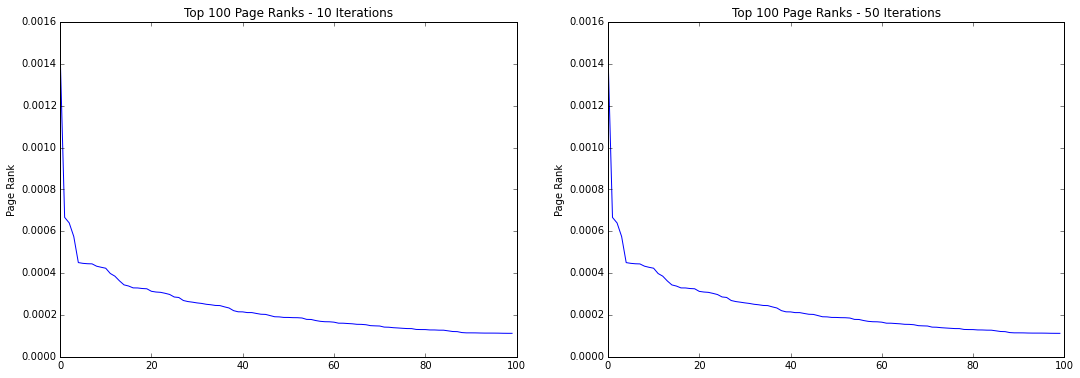

In [168]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Top 100 Page Ranks - 10 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[0] for pr in pr1])

plt.subplot(122)
plt.title("Top 100 Page Ranks - 50 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[0] for pr in pr2])

## HW 13.4: Criteo Phase 2 baseline
___

SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.

The  Criteo data is located in the following S3 bucket:  criteo-dataset 
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=

Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:

-- Number of buckets for hashing: 1,000
-- Logistic Regression: no regularization term
-- Logistic Regression: step size = 10

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

Dont forget to put a caption on your tables (above each table).

### [Modified HW13] Using Raw Dataset
___


In [194]:
%%writefile spark_13_4_v2.py
import ast
import pprint
import sys
from math import log, exp
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics


def parse_line(line):
    t = ast.literal_eval(line)
    return LabeledPoint(t[0], SparseVector(t[1][0], t[1][1], t[1][2]))

def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return [(i-1, val) for i, val in enumerate(point.split(',')) if i > 0]

from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = {}
    for bucket in mapping.values():
        sparseFeatures[bucket] = sparseFeatures.get(bucket, 0) + 1.0
    return sparseFeatures

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    label = point.split(",")[0]
    feature_list = parsePoint(point)
    dict_hashed_features = hashFunction(numBuckets, feature_list)
    return LabeledPoint(label, SparseVector(numBuckets, dict_hashed_features))

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        p = p + epsilon
    if p == 1:
        p = p - epsilon
    return -(y * log(p) + (1-y) * log(1-p))

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1 / (1 + exp(-rawPrediction))

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    labelPredictions = data.map(lambda lp: (getP(lp.features, model.weights, model.intercept), lp.label))
    return labelPredictions.map(lambda (p,l): computeLogLoss(p,l)).sum() / labelPredictions.count()

def metrics(model, data, label):
    labelsAndScores = data.map(lambda lp:
                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
    
    metrics = BinaryClassificationMetrics(labelsAndScores)
    log_loss = evaluateResults(model0, data)
    auc = metrics.areaUnderROC
    sys.stderr.write('\n [{0}] LogLoss: {1}'.format(label, log_loss))
    sys.stderr.write('\n [{0}] AUC: {1}\n'.format(label, auc))
    return (label, log_loss, auc)


if __name__ == '__main__':
    sys.stderr.write('\nNumber of arguments: {0}'.format(len(sys.argv)))
    sys.stderr.write('\nArgument List: {0}'.format(sys.argv))
    
    if len(sys.argv) != 6:
        print 'Incorrect number of arguments passed, Aborting...'
        sys.exit(1)
        
    # Init Spark Context
    #conf = SparkConf()
    sc = SparkContext(appName="Logistic Regression")
    
    numBucketsCTR = int(sys.argv[5])
    
    OHETrainData = sc.textFile(sys.argv[1]) \
                     .map(lambda x: x.replace('\t', ',')) \
                     .map(lambda point: parseHashPoint(point, numBucketsCTR)).cache()
    OHETestData = sc.textFile(sys.argv[2]) \
                     .map(lambda x: x.replace('\t', ',')) \
                     .map(lambda point: parseHashPoint(point, numBucketsCTR)).cache()
    OHEValidateData = sc.textFile(sys.argv[3]) \
                     .map(lambda x: x.replace('\t', ',')) \
                     .map(lambda point: parseHashPoint(point, numBucketsCTR)).cache()
    
    #print '\n', OHETrainData.take(3)
    
    # fixed hyperparameters
    numIters = 50
    stepSize = 10.
    #regParam = 1e-6
    regParam = 0. # No Reg
    regType = 'l2'
    includeIntercept = True
    
    model0 = LogisticRegressionWithSGD.train(OHETrainData, iterations=numIters, step=stepSize, 
                                   regParam=regParam, regType=regType, intercept=includeIntercept)
    sortedWeights = sorted(model0.weights)
    
    
    
    sys.stderr.write('\n### Model Intercept: {0}'.format(model0.intercept))
    sys.stderr.write('\n### Model Weights (First 5): {0}\n'.format(sortedWeights[:5]))
    
    l = []
    
    l.append(metrics(model0, OHETrainData, 'TRAIN'))
    l.append(metrics(model0, OHETestData, 'TEST'))
    l.append(metrics(model0, OHEValidateData, 'VALIDATE'))
    
    sc.parallelize(l).saveAsTextFile(sys.argv[4])

Overwriting spark_13_4_v2.py


In [195]:
!chmod u+x spark_13_4_v2.py

### Testing in Local

In [196]:
out_dir = "output_13_4_1"
!rm -rf $out_dir
!time $SPARK_HOME/bin/spark-submit --master local[4] ./spark_13_4_v2.py \
                criteo-raw-test criteo-raw-test criteo-raw-test $out_dir 100
!cat $out_dir/part-000* | sort


Number of arguments: 6
Argument List: ['/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk14/./spark_13_4_v2.py', 'criteo-raw-test', 'criteo-raw-test', 'criteo-raw-test', 'output_13_4_1', '100']2015-12-14 18:44:26.014 java[46222:28057188] Unable to load realm mapping info from SCDynamicStore

### Model Intercept: 0.709507605384
### Model Weights (First 5): [-0.90719793449520014, -0.83123699746238977, -0.78322281674239047, -0.73997866314148364, -0.73987972557172177]

 [TRAIN] LogLoss: 1.10996667841
 [TRAIN] AUC: 0.667882179328

 [TEST] LogLoss: 1.10996667841
 [TEST] AUC: 0.667882179328

 [VALIDATE] LogLoss: 1.10996667841
 [VALIDATE] AUC: 0.667882179328

real	3m25.267s
user	0m30.036s
sys	0m4.015s
('TEST', 1.1099666784070232, 0.6678821793284523)
('TRAIN', 1.1099666784070232, 0.6678821793284523)
('VALIDATE', 1.1099666784070232, 0.6678821793284523)


In [199]:
out_dir = "output_13_4_1"
!rm -rf $out_dir;mkdir $out_dir;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/ $out_dir
!cat $out_dir/part-*

download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00001 to output_13_4_1/part-00001
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00000 to output_13_4_1/part-00000
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00005 to output_13_4_1/part-00005
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00003 to output_13_4_1/part-00003
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00004 to output_13_4_1/part-00004
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00006 to output_13_4_1/part-00006
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00007 to output_13_4_1/part-00007
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00010 to output_13_4_1/part-00010
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00009 to output_13_4_1/part-00009
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2/part-00014 to output_13_4_1/part-00014


### Running on AWS

```
/usr/bin/spark-submit /home/hadoop/spark_13_4_v2.py s3n://criteo-dataset/rawdata/train s3n://criteo-dataset/rawdata/test s3n://criteo-dataset/rawdata/validation s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_4_v2 1000
```

***Cluster Size: 10 m3.xlarge***

***Time Taken: 22mins, 12sec ***

**Model Intercept & Weights **


**Log Loss & AUC**
___

| Type | LOG LOSS | AUC |
|---|-----------------------|----------|
| TRAIN | 0.55654348258496389 | 0.64145791271765018    |
| TEST | 0.55642728625674942 | 0.64184676371698468   |
| VALIDATE | 0.5566402689505584 | 0.64143748246139665    |

## HW 13.5: Criteo Phase 2 hyperparameter tuning
___

===HW 13.5: Criteo Phase 2 hyperparameter tuning  ===
SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.

NOTE:  please do  HW 13.5 in groups of 3 

Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

-- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
-- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
-- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.


### [Modified HW13] Using Raw Dataset & hyperameter tuning using different # of Hash Buckets
___

In [201]:
%%writefile spark_13_5_v2.py
import ast
import pprint
import sys
from math import log, exp
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics


def parse_line(line):
    t = ast.literal_eval(line)
    return LabeledPoint(t[0], SparseVector(t[1][0], t[1][1], t[1][2]))

def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return [(i-1, val) for i, val in enumerate(point.split(',')) if i > 0]

from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = {}
    for bucket in mapping.values():
        sparseFeatures[bucket] = sparseFeatures.get(bucket, 0) + 1.0
    return sparseFeatures

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    label = point.split(",")[0]
    feature_list = parsePoint(point)
    dict_hashed_features = hashFunction(numBuckets, feature_list)
    return LabeledPoint(label, SparseVector(numBuckets, dict_hashed_features))

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        p = p + epsilon
    if p == 1:
        p = p - epsilon
    return -(y * log(p) + (1-y) * log(1-p))

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1 / (1 + exp(-rawPrediction))

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    labelPredictions = data.map(lambda lp: (getP(lp.features, model.weights, model.intercept), lp.label))
    return labelPredictions.map(lambda (p,l): computeLogLoss(p,l)).sum() / labelPredictions.count()

def metrics(model, data, label):
    labelsAndScores = data.map(lambda lp:
                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
    
    metrics = BinaryClassificationMetrics(labelsAndScores)
    log_loss = evaluateResults(model0, data)
    auc = metrics.areaUnderROC
    sys.stderr.write('\n [{0}] LogLoss: {1}'.format(label, log_loss))
    sys.stderr.write('\n [{0}] AUC: {1}\n'.format(label, auc))
    return (label, log_loss, auc)


if __name__ == '__main__':
    sys.stderr.write('\nNumber of arguments: {0}'.format(len(sys.argv)))
    sys.stderr.write('\nArgument List: {0}'.format(sys.argv))
    
    if len(sys.argv) != 5:
        print 'Incorrect number of arguments passed, Aborting...'
        sys.exit(1)
        
    # Init Spark Context
    #conf = SparkConf()
    sc = SparkContext(appName="Logistic Regression")
        
    # Tune hyperparameters
    buckets = [1000, 5000]
    numIters = 50
    stepSize = [1,5]
    regParam = [1e-3,1e-6]
    regType = 'l2'
    includeIntercept = True
    
    l = []
    for b in buckets:
        # Hash Data into buckets as per size
        OHETrainData = sc.textFile(sys.argv[1]) \
                     .map(lambda x: x.replace('\t', ',')) \
                     .map(lambda point: parseHashPoint(point, b)).cache()
        OHETestData = sc.textFile(sys.argv[2]) \
                         .map(lambda x: x.replace('\t', ',')) \
                         .map(lambda point: parseHashPoint(point, b)).cache()
        OHEValidateData = sc.textFile(sys.argv[3]) \
                         .map(lambda x: x.replace('\t', ',')) \
                         .map(lambda point: parseHashPoint(point, b)).cache()
                
        for rp in regParam:
            for ss in stepSize:
                model0 = LogisticRegressionWithSGD.train(OHETrainData, iterations=numIters, step=ss, 
                                               regParam=rp, regType=regType, intercept=includeIntercept)
                sortedWeights = sorted(model0.weights)



                sys.stderr.write('\n### Model Intercept: {0}'.format(model0.intercept))
                sys.stderr.write('\n### Model Weights (First 5): {0}\n'.format(sortedWeights[:5]))

                l.append(metrics(model0, OHETrainData, '{0},{1},{2},TRAIN'.format(b,rp,ss)))
                l.append(metrics(model0, OHETestData, '{0},{1},{2},TEST'.format(b,rp,ss)))
                l.append(metrics(model0, OHEValidateData, '{0},{1},{2},VALIDATE'.format(b,rp,ss)))
                
        # Unpersist
        OHETrainData.unpersist()
        OHETestData.unpersist()
        OHEValidateData.unpersist()
    
    sc.parallelize(l).saveAsTextFile(sys.argv[4])

Overwriting spark_13_5_v2.py


In [202]:
!chmod u+x spark_13_5_v2.py

#### Test in Local

In [200]:
out_dir = "output_13_5"
!rm -rf $out_dir
!time $SPARK_HOME/bin/spark-submit --master local[4] ./spark_13_5_v2.py \
                criteo-raw-test.5 criteo-raw-test.5 criteo-raw-test.5 $out_dir
!cat $out_dir/part-* | sort


Number of arguments: 5
Argument List: ['/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk14/./spark_13_5_v2.py', 'criteo-raw-test.5', 'criteo-raw-test.5', 'criteo-raw-test.5', 'output_13_5']2015-12-14 19:07:00.081 java[52220:28082245] Unable to load realm mapping info from SCDynamicStore

### Model Intercept: 0.267745202049
### Model Weights (First 5): [-0.87665805551503406, -0.87665584638057903, -0.73054839827696838, -0.58443971341630663, -0.58443892178881862]

 [1000,0.001,1,TRAIN] LogLoss: 9.63101639099e-06
 [1000,0.001,1,TRAIN] AUC: 0.0

 [1000,0.001,1,TEST] LogLoss: 9.63101639099e-06
 [1000,0.001,1,TEST] AUC: 0.0

 [1000,0.001,1,VALIDATE] LogLoss: 9.63101639099e-06
 [1000,0.001,1,VALIDATE] AUC: 0.0

### Model Intercept: -2.55799399079
### Model Weights (First 5): [-4.2176787131952338, -4.2176787131952338, -3.5147322609960274, -2.8117858087968228, -2.8117858087968228]

 [1000,0.001,5,TRAIN] LogLoss: 2.06115358327e-09
 [1000,0.001,5,TRAIN] AUC: 0.0

 [1000,0.001,5,TEST] LogLoss: 

### Running on AWS

```
/usr/bin/spark-submit /home/hadoop/spark_13_5_v2.py s3n://criteo-dataset/rawdata/train s3n://criteo-dataset/rawdata/test s3n://criteo-dataset/rawdata/validation s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2```

***Cluster Size: 10 m3.xlarge***

***Time Taken: 3hrs, 35mins, 26sec***



#### Downloading Results from S3 Bucket

In [203]:
out_dir = "output_13_5_1"
!rm -rf $out_dir;mkdir $out_dir;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/ $out_dir
!cat $out_dir/part-*

download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00006 to output_13_5_1/part-00006
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00003 to output_13_5_1/part-00003
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00002 to output_13_5_1/part-00002
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00008 to output_13_5_1/part-00008
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/_SUCCESS to output_13_5_1/_SUCCESS
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00001 to output_13_5_1/part-00001
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00004 to output_13_5_1/part-00004
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00000 to output_13_5_1/part-00000
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00007 to output_13_5_1/part-00007
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_5_v2/part-00005 to output_13_5_1/part-00005
down

In [204]:
from tabulate import tabulate
import ast
table = []
cnt = 1
for f_name in glob.glob(out_dir + '/part-*'):
    with open(f_name) as f:
        for l in f:
            t = ast.literal_eval(l)
            tmp =  t[0].split(",")
            tmp.append(t[1])
            tmp.append(t[2])
            table.append(tmp)
            if cnt % 3 == 0:
                table.append(['','','','','',''])
            cnt += 1
print tabulate(table, headers=['Bucket','Reg Param','Step Size','Data Type','Log Loss','AUC'], tablefmt="pipe") 

| Bucket   | Reg Param   | Step Size   | Data Type   | Log Loss       | AUC            |
|:---------|:------------|:------------|:------------|:---------------|:---------------|
| 1000     | 0.001       | 1           | TRAIN       | 0.528703622703 | 0.711774480613 |
| 1000     | 0.001       | 1           | TEST        | 0.528814703817 | 0.713268159424 |
| 1000     | 0.001       | 1           | VALIDATE    | 0.52892588166  | 0.712710614958 |
|          |             |             |             |                |                |
| 1000     | 0.001       | 5           | TRAIN       | 0.51142930777  | 0.692075084184 |
| 1000     | 0.001       | 5           | TEST        | 0.511543878365 | 0.692678810252 |
| 1000     | 0.001       | 5           | VALIDATE    | 0.511632895764 | 0.692457029342 |
|          |             |             |             |                |                |
| 1000     | 1e-06       | 1           | TRAIN       | 0.528607664312 | 0.71118294696  |
| 1000     | 1e-06   